In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
try:
    import bandits_correction as bandits
    print('bandits_correction importé')
    import exp_correction
    print('exp_correction importé')
except:
    # Pour utiliser le code fourni à compléter (étudiants)
    import bandits

In [3]:
# Création d'un problème avec 4 bras
bandits_pb = bandits.BernoulliMultiArmedBanditsEnv(means = [0.1, 0.85, 0.7, 0.849])
print(bandits_pb)

4-arms bandit problem with Bernoulli distributions


# Les agents/algorithmes de bandits: la classe abstraite `BanditAgent`
Dans `bandits.py`, on fournit une classe abstraite `BanditAgent` générique pour les algorithmes de bandits:
* la méthode abstraite `get_action()` renvoie l'action choisie
* la méthode `fit_step(a, r)` prend en argument une action `a` et une récompense `r` obtenue suite à cette action pour apprendre à partir de cet exemple, par exemple en mettant à jour les estimations des valeurs des bras.  Plusieurs sous-classes sont proposées pour les différentes stratégies de résolution.

La plupart des agents doivent mettre à jour le nombre de tirages $N(a)$ de chaque bras $a$ et sa récompense moyenne $Q(a)$: ces valeurs sont stockées sous forme de tableaux numpy dans les attributs `_value_estimates` et `_n_estimates`, respectivement.

# Exploration pure: stratégie aléatoire

On utilise ici la classe `RandomBanditAgent` qui implémente un algorithme de bandit qui choisit une action totalement aléatoirement, sans rien apprendre.

**À faire.** Étudiez le code de cette classe (constructeur, méthodes à `get_action` et `fit_step`).

**À faire sur papier.** Calculez le gain moyen de ce joueur en fonction des vraies valeurs des bras.

Le code ci-dessous est une simulation classique de l'interaction entre un agent/algorithme de bandit et son environnement: choix du bras, récompense, entrainement online.

In [4]:
# Création de l'agent
rand_agent = bandits.RandomBanditAgent(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for _ in range(15):
    i_arm = rand_agent.get_action()  # Choix du bras par l'agent
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
    print(f'Bras {i_arm} -> récompense {r}')

Bras 1 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 2 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 2 -> récompense True
Bras 2 -> récompense True
Bras 3 -> récompense False
Bras 1 -> récompense True
Bras 0 -> récompense False
Bras 2 -> récompense True


In [6]:
# On cherche à tracer le regret sur un grand nombre d'itérations
n_draws = 10**4  # On pourra augmenter ce nombre à 10**5 une fois que le code fonctionne bien pour aller plus loin dans les itérations

# Simulation
rand_agent = bandits.RandomBanditAgent(n_arms=bandits_pb.n_arms)
rewards_rand = np.empty(n_draws)
selected_arms_rand = np.empty(n_draws)
for i in range(n_draws):
    i_arm = rand_agent.get_action()  # Choix du bras par l'agent
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
    rewards_rand[i] = r
    selected_arms_rand[i] = i_arm
# Calcul du regret sur une simu
r_max = np.max(bandits_pb._true_values)  # Gain moyen du bras optimal
cum_reward_rand = np.cumsum(rewards_rand)  # Récompenses cumulées
regret_rand = np.arange(1, n_draws+1) * r_max - cum_reward_rand

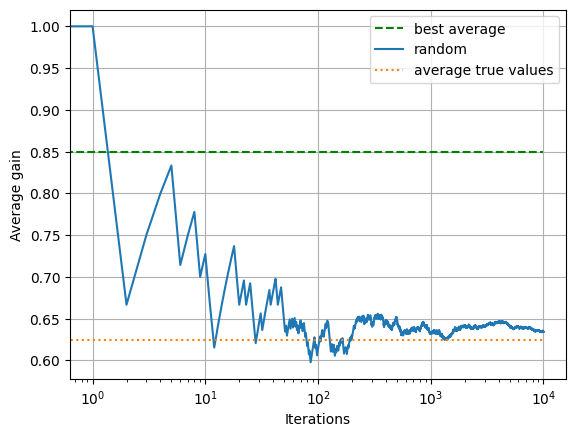

In [7]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx([0, n_draws-1], [np.mean(bandits_pb._true_values)] * 2, ':', label='average true values')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.grid()
plt.legend()

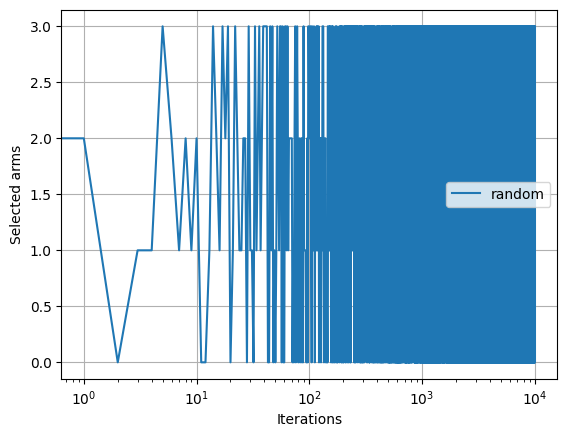

In [8]:
# Les bras sélectionnés
plt.semilogx(selected_arms_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
plt.grid()

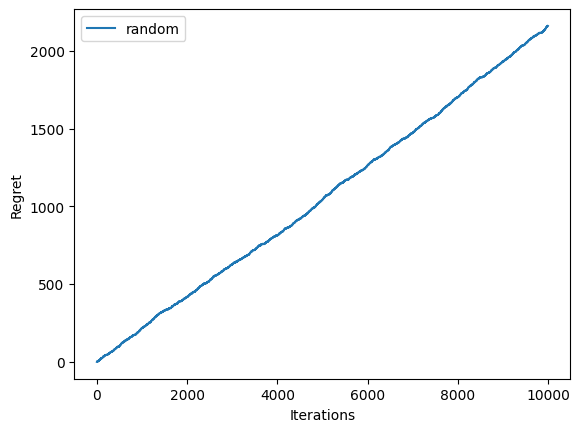

In [9]:
# Le regret sur une simu
plt.plot(regret_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.legend()

# Exploitation pure: stratégie greedy

**Question à chercher sur papier.** On cherche à mettre à jour les moyennes des gains de chaque bras de façon online. Pour tout $n>0$, on note $\mu_n=\frac{1}{n}\sum_{i=1}^{n} x_i$ la moyenne de $n$ valeurs $x_i$, avec $\mu_0=0$. Montrer mathématiquement que pour tout $n>1$, on a $\mu_n = \mu_{n-1} + \frac{1}{n} \left (x_n - \mu_{n-1}\right )$.

**À faire.** En utilisant la formule précédentes, complétez la méthode `fit_step` de la classe `GreedyBanditAgent` puis implémentez sa méthode `get_action`.

In [10]:
# Création de l'agent
greedy_agent = bandits.GreedyBanditAgent(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    if i >= bandits_pb.n_arms:
        i_arm = greedy_agent.get_action()
    else:
        i_arm = i
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense False
Bras 1 -> récompense True
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense False


In [11]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(3)
greedy_agent = bandits.GreedyBanditAgent(n_arms=bandits_pb.n_arms)
rewards_greedy = np.empty(n_draws)
selected_arms_greedy = np.empty(n_draws)
for i in range(n_draws):
    if i >= bandits_pb.n_arms:
        i_arm = greedy_agent.get_action()
    else:
        i_arm = i
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
    rewards_greedy[i] = r
    selected_arms_greedy[i] = i_arm
cum_reward_greedy = np.cumsum(rewards_greedy)  # Récompenses cumulées


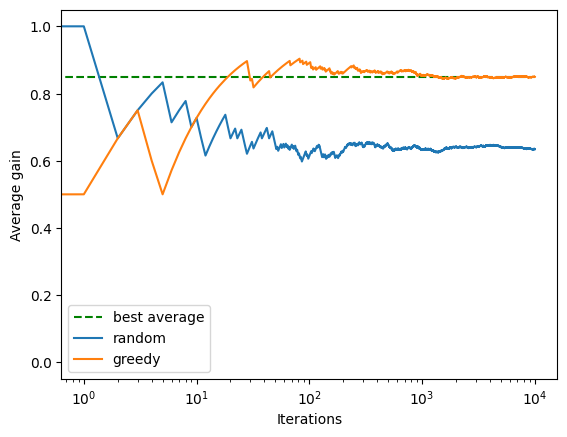

In [12]:
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

[0.1   0.85  0.7   0.849]
[0.         0.5        0.5        0.84972486]


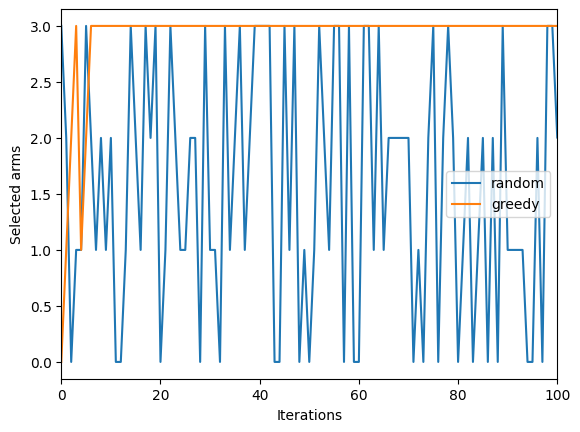

In [13]:
plt.plot(selected_arms_rand, label='random')
plt.plot(selected_arms_greedy, label='greedy')
plt.xlim(0, 100)
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print(bandits_pb._means)
print(greedy_agent._value_estimates)

**À faire.** La stratégie greedy peut rester piégée dans un mauvais choix. Répétez l'expérience précédente un grand nombre de fois (50) en réinitialisant l'algorithme à chaque fois; calculer ensuite un regret empirique en faisant des moyennes par rapport à toutes les initialisations de l'algorithme et tracez-le.

In [14]:
for _ in range(50):
    greedy_agent = bandits.GreedyBanditAgent(n_arms=bandits_pb.n_arms)
    rewards_greedy = np.empty(n_draws)
    selected_arms_greedy = np.empty(n_draws)
    for i in range(n_draws):
        if i >= bandits_pb.n_arms:
            i_arm = greedy_agent.get_action()
        else:
            i_arm = i
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        greedy_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
        rewards_greedy[i] = r
        selected_arms_greedy[i] = i_arm
    cum_reward_greedy = np.cumsum(rewards_greedy)


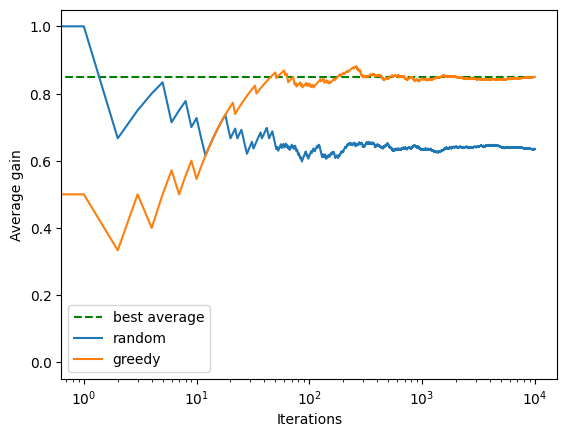

In [15]:
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

[0.1   0.85  0.7   0.849]
[0.         0.5        0.         0.84963986]


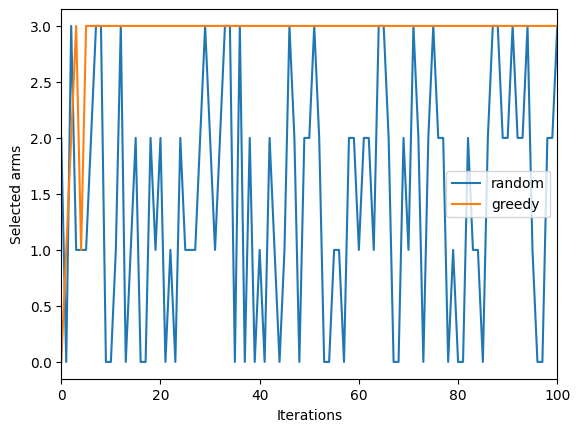

In [32]:
plt.plot(selected_arms_rand, label='random')
plt.plot(selected_arms_greedy, label='greedy')
plt.xlim(0, 100)
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print(bandits_pb._means)
print(greedy_agent._value_estimates)

In [33]:
# Correction
try:
    my_vars = dict()
    my_vars['bandits_pb'] = bandits_pb
    my_vars['n_draws'] = n_draws
    my_vars['regret_rand'] = regret_rand
    my_vars['cum_reward_rand'] = cum_reward_rand
    exp_correction.exp_greedy(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie $\epsilon$-greedy
**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `EpsilonGreedyBanditAgent`, réalisez l'expérience précédente dans le cas de la stratégie $\epsilon$-greedy et tracez les résultats de toutes les stratégies en les superposant. Vous pourrez fixer $\epsilon=0.01$ dans un premier temps. Tester ensuite plusieurs valeurs de $\epsilon$ telles que $\epsilon=0.1$ et $\epsilon=0$, superposez les courbes et commentez-les.

In [28]:
epsilon = [0.1, 0.01]

In [31]:
def run(e):
    for _ in range(1):
        greedy_agent = bandits.EpsilonGreedyBanditAgent(
            epsilon=e,
            n_arms=bandits_pb.n_arms
        )

        rewards_greedy = np.empty(n_draws)
        selected_arms_greedy = np.empty(n_draws)
        for i in range(n_draws):
            if i >= bandits_pb.n_arms:
                i_arm = greedy_agent.get_action()
            else:
                i_arm = i
            r = bandits_pb.step(i_arm)
            greedy_agent.fit_step(action=i_arm, reward=r)  # mise à jour de l'agent
            rewards_greedy[i] = r
            selected_arms_greedy[i] = i_arm
        cum_reward_greedy = np.cumsum(rewards_greedy)
        plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label=f'greedy with e: {e}')

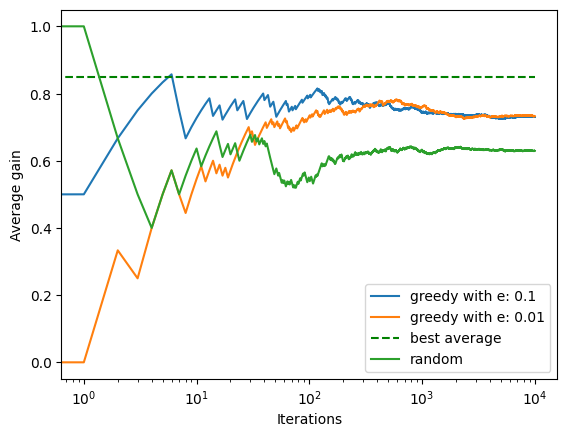

In [32]:
for e in epsilon:
    run(e)
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

In [22]:
# Correction
try:
    from exp_correction import exp_epsgreedy_1
    exp_epsgreedy_1(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


In [ ]:
# Correction
try:
    exp_correction.exp_epsgreedy_50(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

 # Stratégie UCB

**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `UcbBanditAgent`, réalisez l'expérience précédente dans le cas de la stratégie UCB et tracez les résultats de toutes les stratégies en les superposant.

In [ ]:
ucb = bandits.UcbBanditAgent(c=1, n_arms=bandits_pb.n_arms)

**À faire.** Pour UCB, tracez, en fonction des itérations, la moyenne et la borne supérieure de chaque bras en superposant les courbes sur un unique graphique (dans le même esprit que dans le cours). Analysez la figure obtenue.

In [ ]:
# À compléter

In [ ]:
# Correction
try:
    exp_correction.exp_ucb_tracking(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

 # Stratégie Thomson Sampling
 **À faire (séance 2).** Complétez les méthodes `fit_step` et `get_action` de la classe `ThompsonSamplingAgent`, réalisez l'expérience précédente dans le cas de la stratégie Thomson Sampling et tracez les résultats de toutes les stratégies en les superposant.

In [ ]:
# À compléter

In [ ]:
# Correction
try:
    exp_correction.exp_ts(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")